# Detecting Facial Features

### Making all necessary imports

In [21]:
import os
import gdown
import kagglehub
import zipfile

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

### Loading the Gender Dataset

fatal: destination path 'fairface' already exists and is not an empty directory.


Downloading...
From (original): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
From (redirected): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86&confirm=t&uuid=a48a9c19-bbcd-408a-b00e-545c4f8ef027
To: /content/fairface-img-margin125-trainval.zip
100%|██████████| 578M/578M [00:03<00:00, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
To: /content/fairface_label_train.csv
100%|██████████| 3.79M/3.79M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/fairface_label_val.csv
100%|██████████| 448k/448k [00:00<00:00, 124MB/s]


Train Labels Sample:
          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


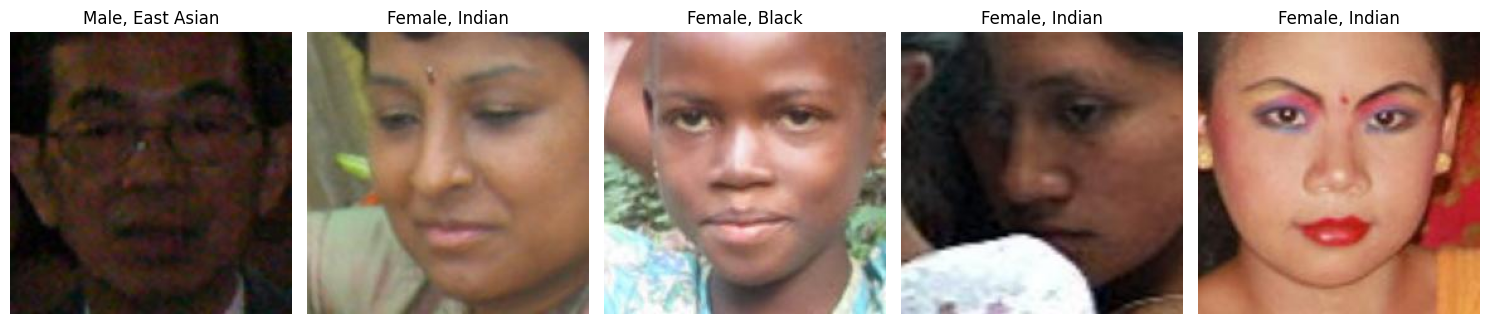

In [29]:
!git clone https://github.com/joojs/fairface.git
os.system("git clone https://github.com/joojs/fairface.git")

# Download cropped images
url = "https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86"  # fairface-img-margin125-trainval.zip
output = "fairface-img-margin125-trainval.zip"
gdown.download(url, output, quiet=False)

# Extract the images from zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("fairface_data")

# Download train labels
train_url = "https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH"
train_csv = "fairface_label_train.csv"
gdown.download(train_url, train_csv, quiet=False)

# Download val labels
val_url = "https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D"
val_csv = "fairface_label_val.csv"
gdown.download(val_url, val_csv, quiet=False)

#Read labels in a dataframe
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

print("Train Labels Sample:")
print(train_df.head())

image_folder = "/content/fairface_data"

# Display 5 images from the FairFace train dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    row = train_df.iloc[i]
    img_path = os.path.join(image_folder, row['file'])
    img = Image.open(img_path).convert('RGB')

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{row['gender'].capitalize()}, {row['race']}")

plt.tight_layout()
plt.show()

**Making sure there is no bias against any race or gender**

In [3]:
train_df['race'].value_counts()

,count
race,
White,16527
Latino_Hispanic,13367
Indian,12319
East Asian,12287
Black,12233
Southeast Asian,10795
Middle Eastern,9216


In [6]:
trainfinal = train_df[(train_df['race'] == 'White') & (train_df['gender'] == 'Male')].head(2400)
trainfinal = pd.concat([
    trainfinal,
    train_df[(train_df['race'] == 'Black') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'Southeast Asian') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'Latino_Hispanic') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'Indian') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'East Asian') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'Middle Eastern') & (train_df['gender'] == 'Male')].head(2400),
    train_df[(train_df['race'] == 'Black') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'Southeast Asian') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'Latino_Hispanic') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'Indian') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'East Asian') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'Middle Eastern') & (train_df['gender'] == 'Female')].head(2400),
    train_df[(train_df['race'] == 'White') & (train_df['gender'] == 'Female')].head(2400)
], ignore_index=True)

valfinal = val_df[(val_df['race'] == 'White') & (val_df['gender'] == 'Male')].head(600)
valfinal = pd.concat([
    valfinal,
    val_df[(val_df['race'] == 'Black') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'Southeast Asian') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'Latino_Hispanic') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'Indian') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'East Asian') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'Middle Eastern') & (val_df['gender'] == 'Male')].head(600),
    val_df[(val_df['race'] == 'Black') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'Southeast Asian') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'Latino_Hispanic') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'Indian') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'East Asian') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'Middle Eastern') & (val_df['gender'] == 'Female')].head(600),
    val_df[(val_df['race'] == 'White') & (val_df['gender'] == 'Female')].head(600)
], ignore_index=True)

print(trainfinal.shape)
print(valfinal.shape)

(33600, 5)
(8196, 5)


### Loading dataset for people with and without glasses

Path to dataset files: /kaggle/input/people-with-and-without-glasses-dataset
['Images']
['glasses', 'no_glasses']
                                          image_path  glasses
0  /kaggle/input/people-with-and-without-glasses-...        1
1  /kaggle/input/people-with-and-without-glasses-...        0
2  /kaggle/input/people-with-and-without-glasses-...        1
3  /kaggle/input/people-with-and-without-glasses-...        0
4  /kaggle/input/people-with-and-without-glasses-...        0
Total images: 4920
glasses
1    2769
0    2151
Name: count, dtype: int64


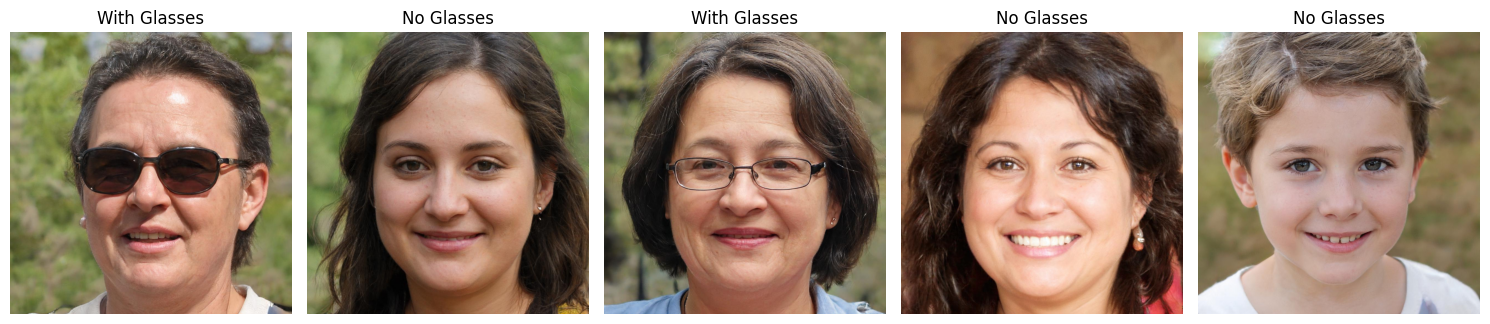

In [26]:
path = kagglehub.dataset_download("saramhai/people-with-and-without-glasses-dataset")
print("Path to dataset files:", path)

# See folders inside the downloaded dataset
print(os.listdir(path))
print(os.listdir(os.path.join(path, 'Images')))
with_glasses_path = os.path.join(path, 'Images', 'glasses')
without_glasses_path = os.path.join(path, 'Images', 'no_glasses')

# Collect image paths
with_glasses_images = [os.path.join(with_glasses_path, img) for img in os.listdir(with_glasses_path) if img.endswith(('.jpg', '.png'))]
without_glasses_images = [os.path.join(without_glasses_path, img) for img in os.listdir(without_glasses_path) if img.endswith(('.jpg', '.png'))]

# Create DataFrames
df_with_glasses = pd.DataFrame({
    'image_path': with_glasses_images,
    'glasses': 1
})

df_without_glasses = pd.DataFrame({
    'image_path': without_glasses_images,
    'glasses': 0
})

# Combine the two
glasses_df = pd.concat([df_with_glasses, df_without_glasses], ignore_index=True)
glasses_df = glasses_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(glasses_df.head())
print("Total images:", len(glasses_df))
print(glasses_df['glasses'].value_counts())

# Display 5 images from glasses_df
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    row = glasses_df.iloc[i]
    img = Image.open(row['image_path']).convert('RGB')

    axes[i].imshow(img)
    axes[i].axis('off')
    label = "With Glasses" if row['glasses'] == 1 else "No Glasses"
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# 80-20 split
glasses_train_df, glasses_val_df = train_test_split(
    glasses_df,
    test_size=0.2,
    stratify=glasses_df['glasses'],  # keep label balance
    random_state=42
)

### Loading shirts dataset

Path to dataset files: /kaggle/input/apparel-dataset
['yellow_skirt', 'white_pants', 'white_suit', 'black_pants', 'white_shoes', 'pink_hoodie', 'brown_shoes', 'blue_shirt', 'green_shoes', 'blue_pants', 'white_shorts', 'red_pants', 'blue_shoes', 'black_dress', 'red_shirt', 'red_hoodie', 'green_pants', 'black_shorts', 'black_suit', 'red_shoes', 'yellow_dress', 'pink_pants', 'yellow_shorts', 'blue_dress', 'black_shirt', 'red_dress', 'green_shirt', 'brown_hoodie', 'silver_shoes', 'white_dress', 'pink_skirt', 'green_shorts', 'silver_skirt', 'green_suit', 'blue_shorts', 'brown_pants', 'black_shoes']

Filtered folders: ['white_suit', 'pink_hoodie', 'blue_shirt', 'black_dress', 'red_shirt', 'red_hoodie', 'black_suit', 'yellow_dress', 'blue_dress', 'black_shirt', 'red_dress', 'green_shirt', 'brown_hoodie', 'white_dress', 'green_suit']

Color label mapping: {'white': 0, 'pink': 1, 'blue': 2, 'black': 3, 'red': 4, 'yellow': 5, 'green': 6, 'brown': 7}


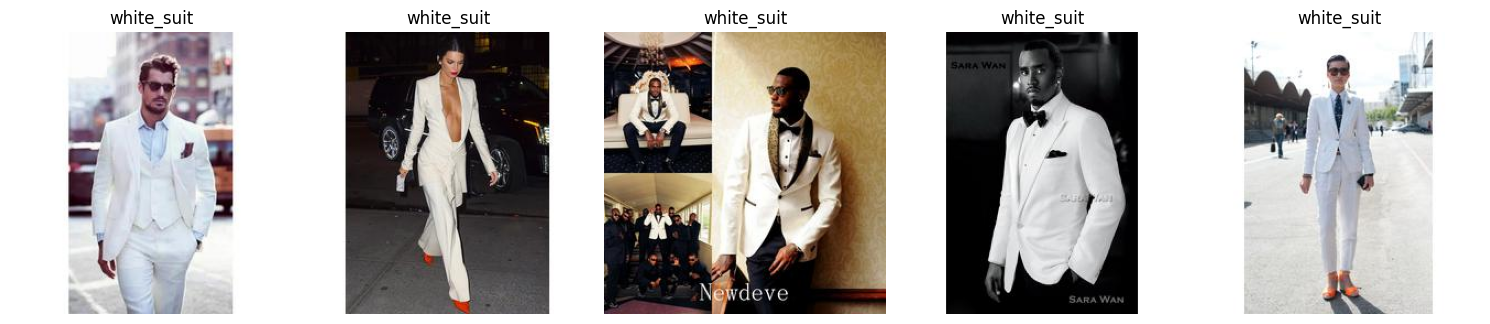

In [25]:
path = kagglehub.dataset_download("kaiska/apparel-dataset")
print("Path to dataset files:", path)
print(os.listdir(path))

# Root path to dataset folders
root_dir = path

# Select only shirt, suit, hoodie, and dress folders
shirt_dress_folders = [f for f in os.listdir(root_dir) if ('shirt' in f or 'dress' in f or 'suit' in f or 'hoodie' in f)]
print("\nFiltered folders:", shirt_dress_folders)

color_to_idx = {}
idx = 0

for folder in shirt_dress_folders:
    color = folder.split('_')[0]
    if color not in color_to_idx:
        color_to_idx[color] = idx
        idx += 1

print("\nColor label mapping:", color_to_idx)

# Display 5 images from the selected folders
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

image_count = 0

for folder in shirt_dress_folders:
    folder_path = os.path.join(root_dir, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert('RGB')

        # Plot the image
        axes[image_count].imshow(img)
        axes[image_count].axis('off')
        axes[image_count].set_title(folder)

        image_count += 1
        if image_count == 5:
            break
    if image_count == 5:
        break

plt.tight_layout()
plt.show()



### Creating DataLoaders for each of the three datasets

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join('fairface_data', row['file'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Prepare labels
        gender = 1 if row['gender'] == 'Male' else 0

        return image, gender

class GlassesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        glasses = row['glasses']

        return image, glasses

class ShirtDressColorDataset(Dataset):
    def __init__(self, root_dir, folders, color_to_idx, transform=None):
        self.samples = []
        self.transform = transform
        self.color_to_idx = color_to_idx

        for folder in folders:
            color = folder.split('_')[0]
            label = color_to_idx[color]
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(folder_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# GENDER DATASET
train_dataset = FaceDataset(trainfinal, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = FaceDataset(valfinal, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# GLASSES DATASET
glasses_train_dataset = GlassesDataset(glasses_train_df, transform=transform)
glasses_train_loader = DataLoader(glasses_train_dataset, batch_size=32, shuffle=True)
glasses_val_dataset = GlassesDataset(glasses_val_df, transform=transform)
glasses_val_loader = DataLoader(glasses_val_dataset, batch_size=32, shuffle=False)

# SHIRTS DATASET
full_dataset = ShirtDressColorDataset(root_dir, shirt_dress_folders, color_to_idx, transform)
train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)
shirt_train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
shirt_val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
shirt_train_loader = DataLoader(shirt_train_dataset, batch_size=32, shuffle=True)
shirt_val_loader = DataLoader(shirt_val_dataset, batch_size=32)
print("Shirts Train dataset size:", len(shirt_train_dataset))
print("Shirts Validation dataset size:", len(shirt_val_dataset))

Shirts Train dataset size: 5564
Shirts Validation dataset size: 1391


## The model

### Model Class

In [10]:
class GenderGlassesShirtClassifier(nn.Module):
    def __init__(self, num_shirt_classes):
        super(GenderGlassesShirtClassifier, self).__init__()

        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)

        # Freeze all layers except the last block and FC
        for name, param in self.backbone.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Gender head (binary classification)
        self.gender_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Glasses head (binary classification)
        self.glasses_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Shirt color head (multiclass classification)
        self.shirt_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_shirt_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        gender_out = torch.sigmoid(self.gender_head(features))
        glasses_out = torch.sigmoid(self.glasses_head(features))
        shirt_out = self.shirt_head(features)
        return gender_out, glasses_out, shirt_out


### Training and Validation Loops

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, criterion, task='gender'):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc=f"Training {task}")
    for images, labels in pbar:
        images = images.to(device)

        optimizer.zero_grad()

        gender_out, glasses_out, shirt_out = model(images)

        if task == 'gender':
            labels = labels.to(device).float().unsqueeze(1)
            preds = gender_out
            loss = criterion(preds, labels)

        elif task == 'glasses':
            labels = labels.to(device).float().unsqueeze(1)
            preds = glasses_out
            loss = criterion(preds, labels)

        elif task == 'shirt':
            labels = labels.to(device).long()
            preds = shirt_out
            loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(loader)

def validate(model, loader, criterion, task='gender'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Validating {task}")
        for images, labels in pbar:
            images = images.to(device)

            gender_out, glasses_out, shirt_out = model(images)

            if task == 'gender':
                labels = labels.to(device).float().unsqueeze(1)
                preds = gender_out
                loss = criterion(preds, labels)
                pred_labels = (preds > 0.5).float()

            elif task == 'glasses':
                labels = labels.to(device).float().unsqueeze(1)
                preds = glasses_out
                loss = criterion(preds, labels)
                pred_labels = (preds > 0.5).float()

            elif task == 'shirt':
                labels = labels.to(device).long()
                preds = shirt_out
                loss = criterion(preds, labels)
                pred_labels = torch.argmax(preds, dim=1)

            total_loss += loss.item()
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix(loss=loss.item(), acc=correct / total)

    return total_loss / len(loader), correct / total

### Training the Model

In [12]:
model = GenderGlassesShirtClassifier(num_shirt_classes=8).to(device)

criterion_bce = nn.BCELoss()
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs=5

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    gender_train_loss = train_one_epoch(model, train_loader, optimizer, criterion_bce, task='gender')
    gender_val_loss, gender_val_acc = validate(model, val_loader, criterion_bce, task='gender')

    glasses_train_loss = train_one_epoch(model, glasses_train_loader, optimizer, criterion_bce, task='glasses')
    glasses_val_loss, glasses_val_acc = validate(model, glasses_val_loader, criterion_bce, task='glasses')

    shirt_train_loss = train_one_epoch(model, shirt_train_loader, optimizer, criterion_ce, task='shirt')
    shirt_val_loss, shirt_val_acc = validate(model, shirt_val_loader, criterion_ce, task='shirt')

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Gender   -> Train Loss: {gender_train_loss:.4f}, Val Loss: {gender_val_loss:.4f}, Val Acc: {gender_val_acc:.4f}")
    print(f"  Glasses  -> Train Loss: {glasses_train_loss:.4f}, Val Loss: {glasses_val_loss:.4f}, Val Acc: {glasses_val_acc:.4f}")
    print(f"  Shirt    -> Train Loss: {shirt_train_loss:.4f}, Val Loss: {shirt_val_loss:.4f}, Val Acc: {shirt_val_acc:.4f}")

torch.save(model.state_dict(), 'gender_glasses_shirt_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.0MB/s]



Epoch 1/5


Validating shirt: 100%|██████████| 44/44 [00:05<00:00,  8.09it/s, acc=0.981, loss=0.104]



Epoch 1 Summary:
  Gender   -> Train Loss: 0.3689, Val Loss: 0.2925, Val Acc: 0.8676
  Glasses  -> Train Loss: 0.0914, Val Loss: 0.0023, Val Acc: 0.9990
  Shirt    -> Train Loss: 0.3987, Val Loss: 0.0694, Val Acc: 0.9813

Epoch 2/5


Validating shirt: 100%|██████████| 44/44 [00:04<00:00,  9.18it/s, acc=0.973, loss=0.122]



Epoch 2 Summary:
  Gender   -> Train Loss: 0.2216, Val Loss: 0.2764, Val Acc: 0.8804
  Glasses  -> Train Loss: 0.0081, Val Loss: 0.0012, Val Acc: 1.0000
  Shirt    -> Train Loss: 0.0637, Val Loss: 0.0814, Val Acc: 0.9727

Epoch 3/5


Validating shirt: 100%|██████████| 44/44 [00:04<00:00,  9.15it/s, acc=0.98, loss=0.25]



Epoch 3 Summary:
  Gender   -> Train Loss: 0.1206, Val Loss: 0.3282, Val Acc: 0.8815
  Glasses  -> Train Loss: 0.0048, Val Loss: 0.0012, Val Acc: 1.0000
  Shirt    -> Train Loss: 0.0340, Val Loss: 0.0607, Val Acc: 0.9799

Epoch 4/5


Validating shirt: 100%|██████████| 44/44 [00:05<00:00,  8.71it/s, acc=0.975, loss=0.238]



Epoch 4 Summary:
  Gender   -> Train Loss: 0.0728, Val Loss: 0.3693, Val Acc: 0.8782
  Glasses  -> Train Loss: 0.0018, Val Loss: 0.0005, Val Acc: 1.0000
  Shirt    -> Train Loss: 0.0249, Val Loss: 0.0704, Val Acc: 0.9748

Epoch 5/5


Validating shirt: 100%|██████████| 44/44 [00:05<00:00,  8.59it/s, acc=0.976, loss=0.269]



Epoch 5 Summary:
  Gender   -> Train Loss: 0.0548, Val Loss: 0.3764, Val Acc: 0.8827
  Glasses  -> Train Loss: 0.0013, Val Loss: 0.0006, Val Acc: 1.0000
  Shirt    -> Train Loss: 0.0148, Val Loss: 0.0815, Val Acc: 0.9763


### Testing the model on a new image

In [19]:
from google.colab import files
uploaded = files.upload()

Saving istockphoto-869773424-612x612.jpg to istockphoto-869773424-612x612.jpg


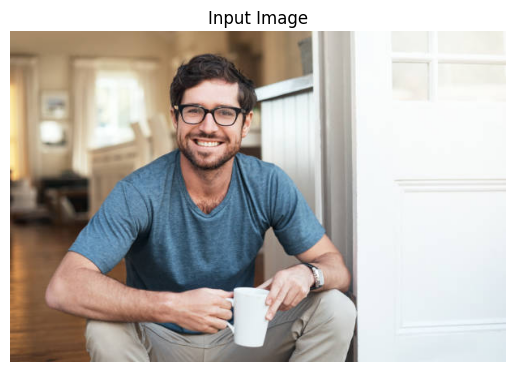

Prediction:
  Gender: Male (0.96)
  Glasses: Wearing Glasses (0.63)
  Shirt: Blue Shirt (Class 0)


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
##################################################

# Replace with your image path
image_path = 'istockphoto-869773424-612x612.jpg'

##################################################

img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    gender_out, glasses_out, shirt_out = model(input_tensor)
    gender_prob = gender_out.item()
    glasses_prob = glasses_out.item()

    # Get the predicted class (index of the highest score)
    shirt_class_idx = shirt_out.argmax(dim=1).item()

    idx_to_class = {
        0: "Blue Shirt",
        1: "Yellow Shirt",
        2: "Black Shirt",
        3: "Green Shirt",
        4: "White Shirt",
        5: "Pink Shirt",
        6: "Red Shirt",
        7: "Brown Shirt"
    }
    shirt_label = idx_to_class[shirt_class_idx]

gender = "Male" if gender_prob > 0.5 else "Female"
glasses = "Wearing Glasses" if glasses_prob > 0.5 else "No Glasses"

print(f"Prediction:")
print(f"  Gender: {gender} ({gender_prob:.2f})")
print(f"  Glasses: {glasses} ({glasses_prob:.2f})")
print(f"  Shirt: {shirt_label} (Class {shirt_class_idx})")
